# ASL Model Training

fvjr156

1. Import required packages.

In [1]:
!pip install tensorflow roboflow ultralytics opencv-python pillow numpy scikit-learn

2. Configure CUDA, loglevel, and memory growth.

In [2]:
import matplotlib.pyplot as pyplot
import tensorflow as tf
import torch
import os

print(f'TensorFlow ver: {tf.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'Device count: {torch.cuda.device_count()}')

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

      # memory depends on GPU, you should adjust it as necessary
      tf.config.experimental.set_virtual_device_configuration(
          gpus[0],
          [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)]  # 6GB limit
      )
  except RuntimeError as e:
    print(e)
else:
  print('No CUDA devices. Will use CPU instead')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to reduce verbose logging
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

TensorFlow ver: 2.18.0
CUDA available: False
Device count: 0
No CUDA devices. Will use CPU instead


3. Allow access to your drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


4. Collect all labels and files from specified directory

In [4]:
import os
import numpy as np

data_dir = '/content/drive/MyDrive/asltraining/data/landmark_sequences/'
class_labels = sorted(os.listdir(data_dir))  # folder names => gesture class labels

sequences = []
sample_labels = []  # per-sample label list

print(f'Found {len(class_labels)} labels: {class_labels}')

for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for filename in os.listdir(label_dir):
        if filename.endswith('.npy'):
            print(f'Found {filename}')
            seq = np.load(os.path.join(label_dir, filename))
            sequences.append(seq)
            sample_labels.append(label)

sequences = np.array(sequences)  # shape: (num_samples, 30, 14  6)
sample_labels = np.array(sample_labels)
print(f'Found {len(sample_labels)} labels: {sample_labels}')


Found 43 labels: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'hello', 'i', 'iloveyou', 'j', 'k', 'l', 'm', 'n', 'no', 'o', 'p', 'please', 'q', 'r', 's', 'sorry', 't', 'thankyou', 'u', 'urwelc', 'v', 'w', 'x', 'y', 'yes', 'z']
Found 1_20250629104029.npy
Found 1_20250629104037.npy
Found 1_20250629104043.npy
Found 1_20250629104049.npy
Found 1_20250629104108.npy
Found 1_20250629104131.npy
Found 1_20250629104135.npy
Found 1_20250629104140.npy
Found 1_20250629104145.npy
Found 1_20250629104150.npy
Found 1_20250629104155.npy
Found 1_20250629104159.npy
Found 1_20250629104207.npy
Found 1_20250629104216.npy
Found 1_20250629104220.npy
Found 1_20250629104231.npy
Found 1_20250629104235.npy
Found 1_20250629104240.npy
Found 1_20250629104315.npy
Found 1_20250629104319.npy
Found 1_20250629104327.npy
Found 1_20250629104335.npy
Found 1_20250629104339.npy
Found 1_20250629104343.npy
Found 1_20250629104347.npy
Found 1_20250629104351.npy
Found 1_20250629104356.npy
Fou

5. Encode labels. Map string labels to integers then to one-hot vector. Train/Test split.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
label_int_encoded = label_encoder.fit_transform(sample_labels)
label_categorical = to_categorical(label_int_encoded)

x_train, x_test, y_train, y_test = train_test_split(
    sequences, label_categorical, test_size=0.2, random_state=42
    )
# here, we split test and train datasets (test takes 20%, train takes 80%)

6. Configure LSTM model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Input(shape=(30, 146)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(label_categorical.shape[1], activation='softmax'))

7. Compile the LSTM model

In [30]:
# stops early with validation loss plataus or increase
early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │       140,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,163 (770.17 KB)

 Trainable params: 197,163 (770.17 KB)

 Non-trainable params: 0 (0.00 B)

8. Then we train. Analyze training curves when finished. Modify epochs to your preferred outcome.

Epoch 1/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0921 - loss: 3.6860
Epoch 1: val_accuracy improved from -inf to 0.28682, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.0944 - loss: 3.6799 - val_accuracy: 0.2868 - val_loss: 3.1802
Epoch 2/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2581 - loss: 3.0433
Epoch 2: val_accuracy improved from 0.28682 to 0.41085, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.2599 - loss: 3.0310 - val_accuracy: 0.4109 - val_loss: 2.2366
Epoch 3/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.4094 - loss: 2.1793
Epoch 3: val_accuracy improved from 0.41085 to 0.51550, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.4115 - loss: 2.1718 - val_accuracy: 0.5155 - val_loss: 1.6948
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5019 - loss: 1.7478
Epoch 4: val_accuracy improved from 0.5155

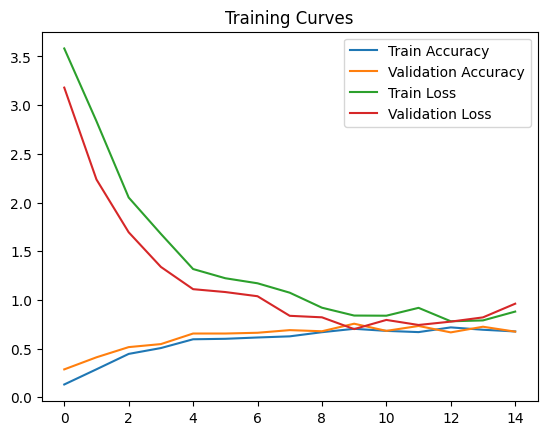

In [31]:
history = model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

pyplot.plot(
    history.history['accuracy'],
    label = 'Train Accuracy'
    )
pyplot.plot(
    history.history['val_accuracy'],
    label = 'Validation Accuracy'
    )
pyplot.plot(
    history.history['loss'],
    label = 'Train Loss'
    )
pyplot.plot(
    history.history['val_loss'],
    label = 'Validation Loss'
    )
pyplot.legend()
pyplot.title("Training Curves")
pyplot.show()

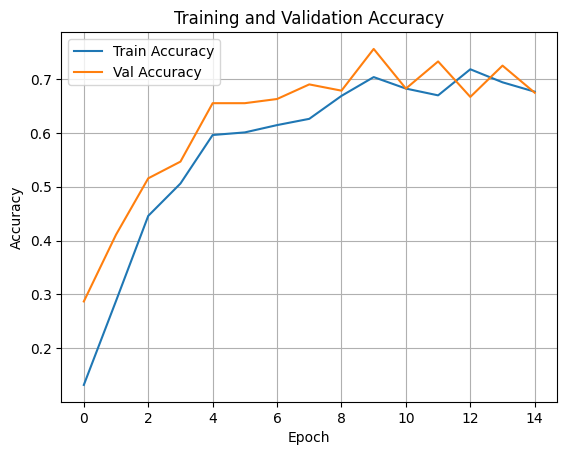

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

9. Evaluate model then save to TensorFlow and TFLite

In [14]:
# evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc:.2f}')

# # saving the model in TensorFlow SavedModel format
# model.export('/content/drive/MyDrive/asltraining/models/asl_model_lstm')
# print("TF saved success.")

# saving the model in Keras v3 native format .keras
model.save('/content/drive/MyDrive/asltraining/models/asl_model_lstm.keras')
print("Keras saved success.")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7925 - loss: 0.4567
Test accuracy: 0.79
Saved artifact at '/content/drive/MyDrive/asltraining/models/asl_model_lstm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 146), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  134764393016272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758557142288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134764393013584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422373456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422371536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422374992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422375568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422377488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758422377104: TensorSp

In [34]:
from tensorflow import lite
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/asltraining/models/asl_model_lstm.keras')
best_model = load_model('best_model.keras')

converter = lite.TFLiteConverter.from_keras_model(model)
converter2 = lite.TFLiteConverter.from_keras_model(best_model)

converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,       # TFLite native ops
    tf.lite.OpsSet.SELECT_TF_OPS          # Add fallback to full TF ops (e.g., TensorList)
]
converter._experimental_lower_tensor_list_ops = False  # Important for LSTM/GRU support

converter2.experimental_enable_resource_variables = True
converter2.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter2._experimental_lower_tensor_list_ops = False

# add optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
tflite_model2 = converter2.convert()

with open('/content/drive/MyDrive/asltraining/models/asl_model_lstm_quant.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model saved successfully.")

with open('/content/drive/MyDrive/asltraining/models/asl_model_lstm_quant_best_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("TFLite model (from best_model.keras) saved successfully.")

Saved artifact at '/tmp/tmpyv9xvdtu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 146), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  134758095044432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092850960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092851536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092850768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092852880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092853456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092853648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092854224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092851920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134758092854992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact at '/

Optional: Confusion matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


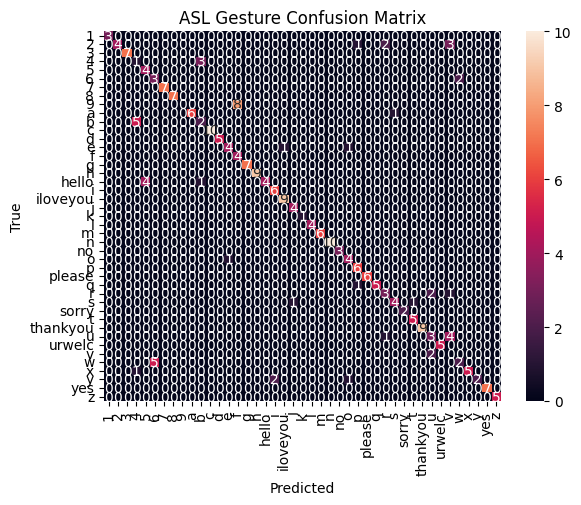

<Figure size 1200x1200 with 0 Axes>

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
cm = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1)
)

sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ASL Gesture Confusion Matrix')
plt.figure(figsize=(12, 12))
plt.show()

In [40]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/asltraining/models/asl_model_lstm_quant.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'serving_default_input_layer:0', 'index': 0, 'shape': array([  1,  30, 146], dtype=int32), 'shape_signature': array([ -1,  30, 146], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 48, 'shape': array([ 1, 43], dtype=int32), 'shape_signature': array([-1, 43], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
